# Testing Kinetics Models

This chapter discusses testing kinetics models. We begin with a motivating example, and then the next two sections provide details of verification testing.
The final section applies these techniques to the running example of glycolytic oscillations.

In [1]:
# Python packages used in this section
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from SBMLLint.tools.sbmllint import lint

## Motivation
We begin with a motivating example.
Consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.

We initialize ``S1`` to 10. We expect that the following outcomes (designated by **On**):

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 

Here is a first implementation of the model.

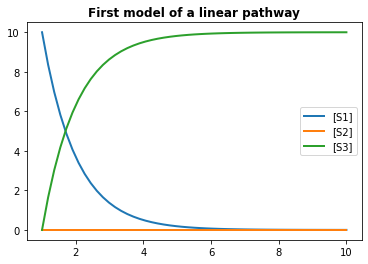

In [2]:
FIRST_IMPLEMENTATION = '''
R1: S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S1

S1 = 10
k1 = 1; k2 = 1
'''
rr = te.loada(FIRST_IMPLEMENTATION)
data = rr.simulate(1, 10)
rr.plot(data, title="First model of a linear pathway")

We see that O1 and O3 are satisfied. However, O2 is not. Why?

Looking carefully at the Antimony model, we see there is an error in the specification of the kinetics law for reaction ``R2``. The kinetics law incorrectly references ``S1`` instead of ``S2``. Below is the corrected model.

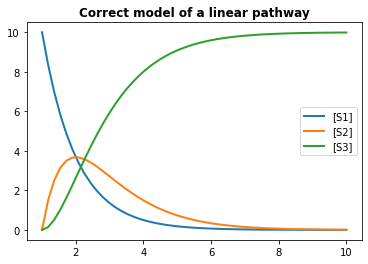

In [3]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(1, 10)
rr.plot(data, title="Correct model of a linear pathway")

In this model, all three outcomes are satisfied.

Although the example is simple, it demonstrates how easy it is to make mistakes in the construction of models, especially complex models. A few mistakes can be detected by tellurium, such as misspelling the name of a floating species. However, the mistake made in the first model, substituting ``S1`` for ``S2``, is not detected by Tellurium.

How do we detect errors in the implementation of models (a processing often referred to as *verification*)? By implementation of the model, we mean that there is a clear understanding of the expected behavior of the model. Verification is about providing ways to detect if the implemention provides the expected behavior.

Although our focus here is on verification, making sure that the intended model is what was built, there is another challenge in modeling. That is, choosing the corrrect model to implement.
Modellers address this by checking for correspondence between simulation data and laboratory measurements.
This process is called **validation**.
Both verification and validation are essential to producing useful models.
However, it makes no sense to validate a model that is implemented incorrectly.
Further, while there is considerable focus in the literature on model validation, there is almost no discussion of verification.

This chaper is about verifying simulation models, or verification testing.
Such testing is done by examining models and their outputs.
There are two kinds of verification tests.

The first kind of verification tests only examines the model itself; the model is not executed.
We refer to these as **static tests**.
For example, one static test is to look for suspicious kinetics laws, such as the kinetics law for ``R2``
that references a floating species that is neither a reactant nor a product (which would be incorrect
if the intended kinetics are mass action).
In the above example, 
Drawing on the experience of the software industry over the last 50 years,
we identify two kinds of validation.

The second kind of verification tests runs simulations and compares the results with what the model developer
expected.
This is illustrated by outcomes O1-O3 and our analysis of the above two simulation models.

The remainder of this chaper discusses static tests, dynamic tests, and provides a detailed example from BioModels.

## Static Testing

Static testing is done by analyzing the model without running any simulation.
Several kinds of errors can be discovered by a static analysis.

### Mass Balance Errors

A first error is the presence of reactions that do not preserve mass balance. Consider the following simulation of ``ATP`` hydrolysis and ``ADP`` phosphorylation. in which the equilibrium constant (``Keq``) is 1. We not that this is not a physiological value for ``Keq``, but useful for our example.

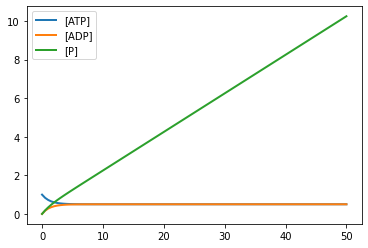

In [4]:
ATP1_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP1_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Our expectation is that at equilibrium, ``ATP = ADP`` by definition of the equilibrium constant. However, instead ``Pi_`` increases without bound,
and ``ATP = 0 = ADP``.

Clearly, we have an error in the model. What is it?

The issue here is that there is mass balance error in the model.
That is, non-boundary reactions (reactions with non-null reactants and non-null products) should neither creater nor destroy mass.
This is the case for ``J0`` in that the third inorganic phosphate in ``ATP`` is one of the products.
However, there is no inorganic phosphate in the reactants of ``J1``. So, we are creating ``P`` in this network.

Below, we revise the model to include ``P`` in the reactants of ``J1a``.

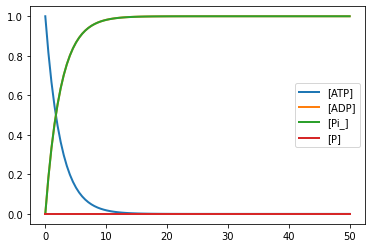

In [5]:
ATP2_MODEL = """
J0: ATP -> ADP + Pi_; k_f*ATP  
J1a: ADP + P -> ATP; k_r*ADP*P

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP2_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Now, we get a more reasonable result. (Note that the line for ``ADP`` and ``Pi`` are coincident.) The concentrations of ``ATP`` and ``ADP`` differ because $K_{eq} = \frac{[ATP]}{[ADP] [Pi]} = \frac{0.64}{(0.4)(0.4)}$.

There is another way of fixing the mass balance error that reqults in ``ATP = ADP``. This solution assumes that there is a
large concentration of ``Pi`` that is relatively unchanged as a result of the hydolysis and phosphorylation reactions.
So, ``Pi`` does not appear in the model.

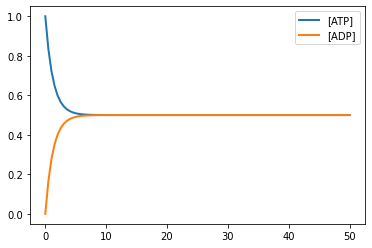

In [6]:
ATP3_MODEL = """
J0a: ATP -> ADP; k_f*ATP 
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP3_MODEL)
rr.plot(rr.simulate(0, 50, 100))

### Detecting Mass Balance Errors

Having seen the dramatic impact of undetected mass balance errors, it is natural to ask how they can be detected. There are two general approaches.
The first requires knowing the chemical composition of each chemical species.
For example, atomic mass analysis ??ref-MEMOTE counts the atoms of each type in the reactants and compares each count with the corresponding counts of atoms in the products.
This approach has two challenges.
First, the modeler must use annotations or other means to expose the chemical structure of species; this is not always available (especially
for larger molecules that can be in many different chemical states of phosphorylation, methylation, etc.).
A second problem is that it forces the modeler to write unnecessarly detailed reactions.
For example, ``ATP2_MODEL`` fails this kind of mass balance checking because there is no accounting for the $\gamma$ phosphate of ``ATP``.

An alternative approach is to check for a condition that is a bit weaker than mass balance.
Referred to as **stoichiometric inconsistency**, such inconsistencies are detected if there is no assignment of masses to
the chemical species such that the reaction network (without boundary reactions) neither creates nor destroys chemical species.

The technical details of this latter approach are described in ??ref-Shin for details.
The paper introduces the GAMES algorithm that uses graphical techniques to analyze mass equivalences implied by the reaction network.
For example, reaction ``J0`` implies that the mass of ``ATP`` is equal to the sum of the masses of ``ADP`` and ``P``.

GAMES is in the SBMLLint ``pip`` installable package. It can be run at the command line
via ``games <SBML file>``. It can also be run programmatically, such as within a Jupyter notebook.
Below, we show how to apply the GAMES to the above examples.


In [7]:
_ = lint(ATP1_MODEL, mass_balance_check="games")

Model analyzed...
At least one error found.


ADP = ATP by reaction(s):
1. J1: ADP -> ATP

However, ADP < ATP by reaction(s):
2. J0: ATP -> ADP + P


----------------------------------------------------------------------



**********************************************************************




GAMES detected that the first model is stoichiometric inconsisent. Further, GAMES provides a simple argument for how this detection is made.
Statement (1) explains that GAMES inferred that the mass of ``ADP`` is equal to the mass of ``ATP``.
However, this is contradicted by a second finding that the mass of ``ADP`` is less than the mass of ``ATP``.

In [8]:
_ = lint(ATP2_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


In [9]:
_ = lint(ATP3_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


### Other Errors Detectable By Static Analysis

There are other errors in reaction networks that can be detected statically. Systems such as MEMOTE detect the following errors:
- *Blocked reactions* are reactions where one or more reactant is never present and so the reaction never ocurs.
- *Dead end metabolite* are chemical species that are produced but not consumed.
- *Orphan metabolites* are chemical species that are consumed but not produced.
- *Charge imbalance* reactions are reactions that do not preserve the charge of the reactants in the products.

The foregoing errors apply to the mass transfer part of reactions. Of course, errors are also possible in the kinetics laws.
Among these errors are:
- *Incorrect reference to chemical species*. To illustrate, consider a reaction in which the modeler intended to use mass action kinetcs, but
wrote the reaction as ``A -> B; kB``.
- *Errors in the function used in the kinetics law*. A common example here is to inadevertently use zeroth order kinetics for
the degradation of a chemical species.
For example, ``B ->; k``. The problem is that this can result in ``B`` becoming negative since its value is reduced
regardless of whether ``B`` is present. Clearly, we cannot have a negative concentration.

## Dynamic Testing

Dynamic testing is about verifying the output produced by a simulation.

This is illustrated at the beginning of the chapter using the example
of a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``, with ``S1`` initialized to 10. 

We showed that the following outcomes were expected from the simulation:

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 


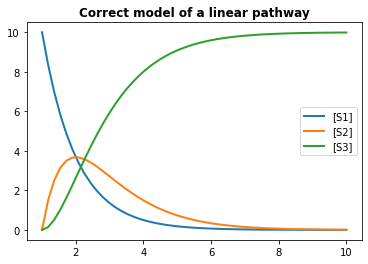

In [10]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(1, 10)
rr.plot(data, title="Correct model of a linear pathway")

#### Testing Expected Outcomes

The expected outcomes are the starting point for constructing verification tests.
Implementing these tests requires two Boolean helper functions.
A Boolean function returns either ``True`` or ``False``.
The first helper function, ``isMonotone``, takes as input a list or array of values and
the direction expected (+1 for monotone increasing and -1 for monotone decreasing).
The function returns ``True`` if the data are monotone in the desired direction.

In [11]:
def isMonotone(values, direction=1):
    # CHeck if series is monotone in the desired direction
    #   direction: 1 (increasing), -1 (decreasing)
    arr = np.array(values)
    diff = direction*(arr[1:] - arr[:-1])
    return all([v > 0 for v in diff])

``isMonotone`` allows us to check the conditions O1 and O3. For O2, we need to check that the values initially increase,
and then decrease. Curves with this shape are called *concave*. That is, there is some intermediate point at which the series changes from increasing to
decreasing. 

In [12]:
def isConcave(values, direction=1):
    # Check if series is monotone in the desired direction
    #   direction: 1 (increasing), -1 (decreasing)
    arr = np.array(values)
    result = False
    for idx in range(1, len(values)-2):
        isIncreasing = isMonotone(arr[:idx], direction=1)
        isDecreasing = isMonotone(arr[idx:], direction=-1)
        if isIncreasing and isDecreasing:
            result = True
            break
    return result

We illustrate these functions below.

In [13]:
# Illustration of isMonotone, isConcave
for values in [ [1, 2, 3, 4], [4, 3, 2, 1], [1, 4, 3, 2]]:
    print("\nAnalyzing the series: %s" % str(values))
    print("  Increasing? %s" % str(isMonotone(values, direction=1)))
    print("  Decreasing? %s" % str(isMonotone(values, direction=-1)))
    print("  Concave? %s" % str(isConcave(values)))


Analyzing the series: [1, 2, 3, 4]
  Increasing? True
  Decreasing? False
  Concave? False

Analyzing the series: [4, 3, 2, 1]
  Increasing? False
  Decreasing? True
  Concave? True

Analyzing the series: [1, 4, 3, 2]
  Increasing? False
  Decreasing? False
  Concave? True


#### Test Infrastructure

Now that we have a way to test the outcomes, we need to write codes that use these tests.
Fortunately, python provides a convenient way to do this with its ``unittest`` infrastructure.
Using the infrastructure requires the following:
- Copy the test template. The template consists of:
  - ``import unittest``
  - ``class TestModel(unittest.TestCase)``
- Write a setUp function within ``TestModel`` that loads the model and gets simulation data.
- Write tests that check the appropriate values in the simulation output.

This is done below for the linear pathway.
Note that the code expects that the variable ``MODEL`` is the antimony codes for the model being tested. We see that there
is a separate test for each column.

In [14]:
import unittest

# Performs unittests on MODEL

# Define a class in which the tests will run
class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = te.loada(MODEL)
        self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
        
    def testS1(self):
        self.assertTrue(expectMonotone(self.data["[S1]"], direction=-1))
          
    def testS2(self):
        self.assertTrue(expectConcave(self.data["[S2]"]))
                
    def testS3(self):
        self.assertTrue(expectMonotone(self.data["[S3]"], direction=1))

To run the model, you assign ``MODEL`` and then run the two lines that follow this assignment.

In [15]:
MODEL = CORRECT_MODEL
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

EEE
ERROR: testS1 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

ERROR: testS2 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

ERROR: testS3 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

------------------------------------------------------------------

These codes ran the 3 tests. All three passed for ``CORRECT_MODEL``. Now consider what happens with the model in ``FIRST_IMPLEMENTATION`` that fails on the test for ``S2``.

In [16]:
MODEL = FIRST_IMPLEMENTATION
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

EEE
ERROR: testS1 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

ERROR: testS2 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

ERROR: testS3 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_102605/1466400500.py", line 10, in setUp
    self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
NameError: name 'ENDTIME' is not defined

------------------------------------------------------------------

We have demonstrated these tests in the Jupyter notebook. However, in practice, the tests would be in
a separate python modeule (a file ending in ``.py``). Ideally, these test files are run whenever there is a
change to the model or its supporting code.
Systems such as ``github`` provide a way to run these tests automatically whenever the model changes, a process referred to
as *continuous integration*.

## Application to Glycolytic Oscillations
This section applies the idea of model testing to our running example of glycolytic oscillations.
We begin by introduce several constants.
Constants are in all capital letters; they are assigned once, and their values do not change.

In [18]:
# Constants used in the section
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = WOLF_RR

NameError: name 'WOLF_RR' is not defined

In this section, we consider tests to verify the simulation of glycolytic oscillations used in our running example. The use case considered is one in which a team plans to modify the original model.
This may involve both the addition and removal of reactions.

Recall that the reactions in this model are:

  ``
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;``

### Static Tests

We begin by checking if the Wolf model has any stoichiometric inconsistencies.
First, we create the antimony model as a string.

In [ ]:
WOLF_ANTIMONY = ROADRUNNER.getAntimony()

Then, we check it.

In [ ]:
_ = lint(WOLF_ANTIMONY, mass_balance_check="games")

### Dynamic Tests

The use case for dynamic tests is that a baseline model, in this case the Wolf model, is being
modified. The specific modifications considered here are changes in parameter values.
We want dynamic tests that ensure that essential characteristics of the model are preserved
when parameter values are changed.

What are these essential characteristics? Answering this question requires looking at the data produced
by the baseline model.

In [ ]:
# Floating species concentrations over time
DATA = ROADRUNNER.simulate(0, ENDTIME, NUMPOINT)
def timePlots(data=DATA):
    p = plt.plot(data[:,0], data[:,1:])
    _ = plt.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
timePlots()

We see that there is an initial transient. But starting at time 1.5 sec to 2 sec, concentrations oscillate. We'll focus on these oscillations in our tests of the model.

One way to characterize oscillations is by using the fourier transform. Below, we introduce the function ``getFft`` that calculates the fast fourier transform
(FFT) for a chemical species, and a second function, ``plotFft``, that plots the FFT.

In [ ]:
 # Codes to obtain the amplitude of the fourier transform and their corresponding frequencies.
def getFft(molecule, data=DATA, offset=100, noZeroFreq=True):
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    if noZeroFreq:
        freqs = freqs[1:]
        fftValues = fftValues[1:]
    return freqs, fftValues
  
# Codes for plotting the amplitude of a fourier transform
def plotFft(molecule, data=DATA, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = getFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])

Using these functions, we construct plots for all of the chemical species in the output.

In [ ]:
# Construct a plot of the amplitude of the fourier transforms of all floating species.
numCol = 4
numRow = 3
fig = plt.figure(figsize=(14,10))
for irow in range(numRow):
    for icol in range(numCol):
        idx = irow*numCol + icol
        if idx >= len(MOLECULES):
            break
        ax = plt.subplot2grid((numRow, numCol), (irow, icol), fig=fig)
        #ax = axes[irow, icol]
        plotFft(MOLECULES[idx], ax=ax)

The above plots use the same scale for the vertical axis ($y$). It seems that all chemical species indicate strong perodicities at a frequency of 5 Hz (5 cycles per second), with harmonics at multiples of this frequency.

Given this, a natural test for the baseline model is that all chemical species show a 5 Hz perodicity. We can check for this using the following codes.

In [ ]:
def expectFrequency(molecule, data=DATA, frequency=5.0, topN=2):
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    freqs, amplitudes = getFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(freqs)), key=lambda i: amplitudes[i], reverse=True)
    # See if the frequency is in the frequencies
    return frequency in list(freqs[sortedIndices[:topN]])

This function caculates the FFT for a chemical species (molecule) and then checks if that frequency is in the top amplitudes. Below
are some examples.

In [ ]:
molecule = "Glucose"
for frequency, topN in [(5.0, 2), (10.0, 10), (6, 20)]:
    print("%s has a frequency of %f in the top %d amplitudes? %s" 
          % (molecule, frequency, topN, str(expectFrequency(molecule, frequency=frequency, topN=topN))))

Now we show how to create a test that can be run on a roadrunner model. We do this making use of the python ``unittest`` infrastructure, as described in previously in this chapter.
For each chemical species considered, we will have two tests.
One test checks that there is a frequency of 5 Hz; the second checks
that there is no frequency of 7 Hz.

In our use case, we consider the model evolving by making modifications to parameter values.
Changes in parameter values are in the python variable ``PARAMETER_DCT``, a python dictionary;
the key is the parameter name, and the value is its new value.
The following provide access to updating parameter values.

Below are the unittests that use ``PARAMETER_DCT`` to modify ``WOLF_MODEL``.

In [ ]:
import unittest

# Define a class in which the tests will run
class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = updateParameters(PARAMETER_DCT)
        self.roadrunner.reset()
        self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
        
    def testGlucoseHasFrequency(self):
        self.assertTrue(expectFrequency("Glucose", data=self.data, frequency=5.0))    
            
    def testGlucoseDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("Glucose", data=self.data, frequency=7.0))   
            
    def testNADHHasFrequency(self):
        self.assertTrue(expectFrequency("NADH", data=self.data, frequency=5.0))    
            
    def testNADHDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("NADH", data=self.data, frequency=7.0))

The function ``updateParameters`` creates a model with whose parameter values are changed to those specified in
a dictionary. The key of the dictionary is the SBML ID of the parameter; the value is the new value for the parameter.

In [ ]:
# Returns a roadrunner model with the desired parameter values
def updateParameters(parameterDct):
    rr = te.loada(WOLF_MODEL)
    for name, value in parameterDct.items():
        rr[name] = value
    return rr

Now, we begin our exploration of parameter values. First, we check that all tests pass if there is no change in parameter value.

In [ ]:
# Run the tests without changing the model
PARAMETER_DCT = {}
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

Next, we consider a small change in the the parameter ``J1_k1`` in the reaction
``J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP`` with the kinetics law ``J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n))``. We change this parameter from its baseline value of 550 to 530.

In [ ]:
# Run tests with changing J1_k1 from 550 to 530.
PARAMETER_DCT = {"J1_k1": 530}
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

This reduction in ``J1_k1`` preserves the frequency characteristics of the chemical species. So, we consider a further reduction in the value of the parameter.

In [ ]:
# Run tests with changing J1_k1 from 550 to 500.
PARAMETER_DCT = {"J1_k1": 500}
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

This time the test fails.